In [ ]:
# Set seeds for reproducibility
import random
random.seed(0)
import numpy as np
np.random.seed(0)
import torch
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
import os
import json
from zipfile import ZipFile
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.models as models
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

# Scikit-learn for metrics
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

In [ ]:
# Install kaggle if needed
import subprocess
import sys

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Install required packages
try:
    import torchvision
except ImportError:
    install_package("torchvision")

try:
    import seaborn as sns
except ImportError:
    install_package("seaborn")

try:
    from tqdm import tqdm
except ImportError:
    install_package("tqdm")
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Install kaggle and download dataset
!pip install kaggle
with open("/content/kaggle.json", "r") as f:
    kaggle_credentials = json.load(f)
os.environ['KAGGLE_USERNAME'] = kaggle_credentials["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentials["key"]
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

# Unzip the dataset
with ZipFile("plantvillage-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()

# Dataset paths
base_dir = 'plantvillage dataset/color'
print("Dataset structure:")
print(os.listdir("plantvillage dataset")[:5])  # First few folders
print(f"Number of classes: {len(os.listdir(base_dir))}")

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
100% 2.03G/2.04G [00:35<00:00, 30.0MB/s]
100% 2.04G/2.04G [00:35<00:00, 62.4MB/s]
Dataset structure:
['color', 'segmented', 'grayscale']
Number of classes: 38


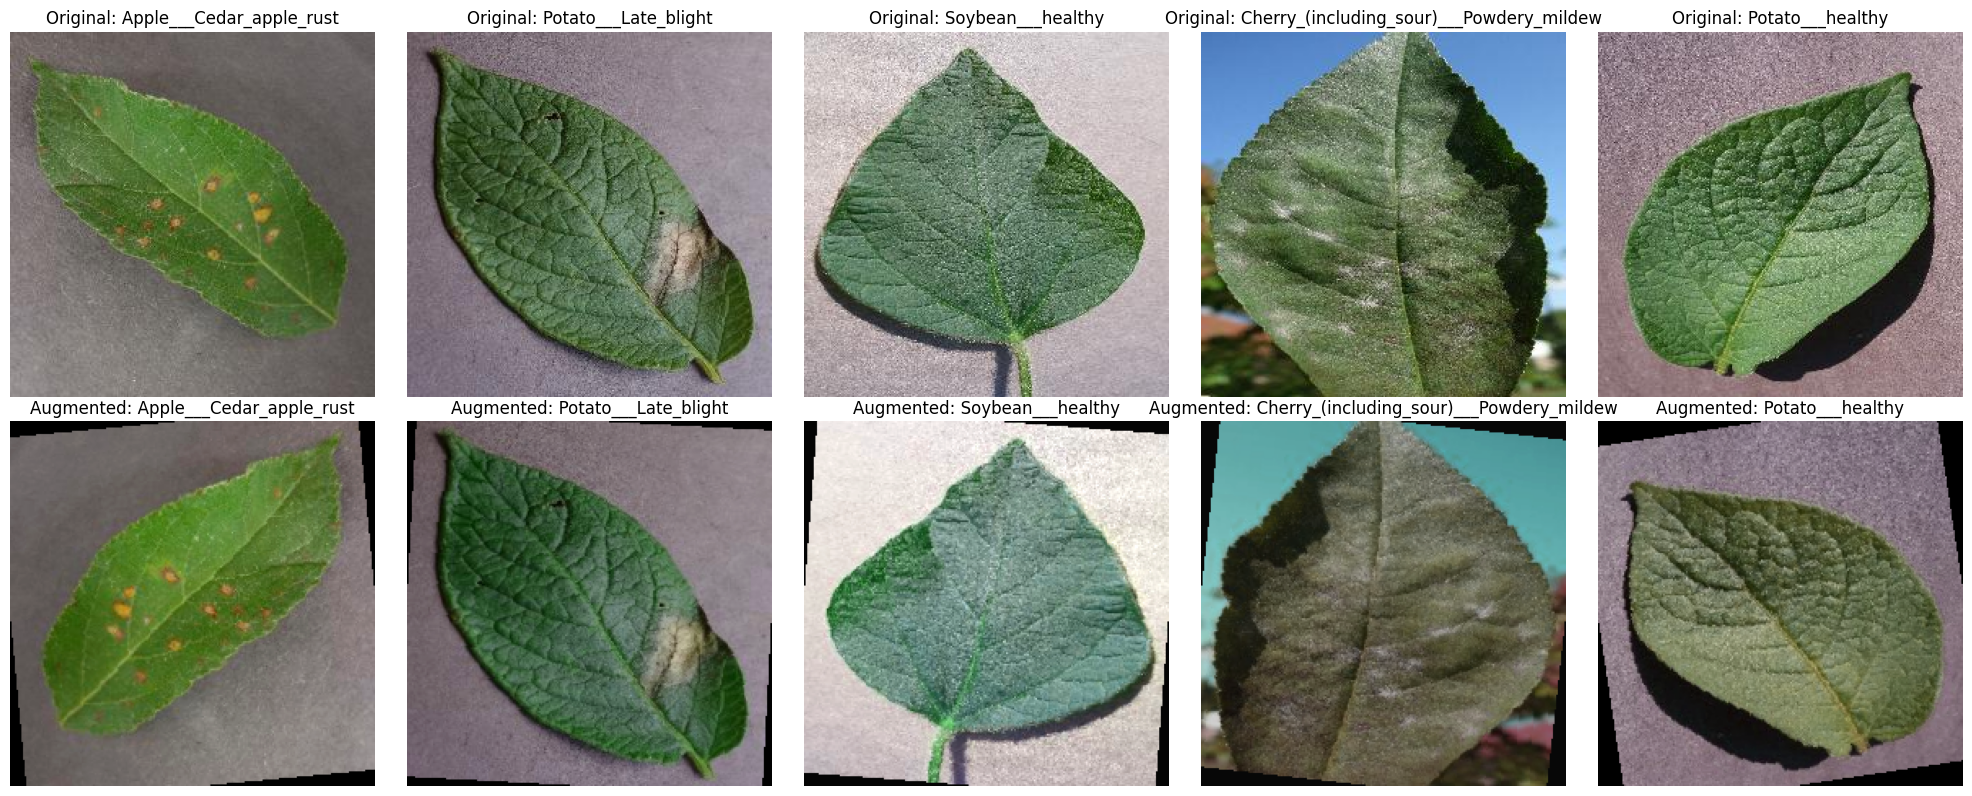

In [ ]:
# Display sample images from a few classes for data inspection
class_names = list(os.listdir(base_dir))[:5]
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, class_name in enumerate(class_names):
    # Original image
    sample_img_path = os.path.join(base_dir, class_name, os.listdir(os.path.join(base_dir, class_name))[0])
    img = plt.imread(sample_img_path)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Original: {class_name}")
    axes[0, i].axis('off')

    # Augmented preview
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    ])
    pil_img = Image.open(sample_img_path).convert('RGB')
    augmented_img = transform(pil_img)
    axes[1, i].imshow(augmented_img)
    axes[1, i].set_title(f"Augmented: {class_name}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Custom Dataset Class
class PlantDiseaseDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
# Data preparation function
def prepare_data(base_dir, test_size=0.2, val_size=0.1):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(base_dir))
    class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

    print("Loading dataset...")
    for class_name in tqdm(class_names):
        class_dir = os.path.join(base_dir, class_name)
        if os.path.isdir(class_dir):
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(class_dir, img_file))
                    labels.append(class_to_idx[class_name])

    print(f"Total images: {len(image_paths)}")
    print(f"Number of classes: {len(class_names)}")
     # Split data
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        image_paths, labels, test_size=test_size, stratify=labels, random_state=42
    )

    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_paths, train_labels, test_size=val_size, stratify=train_labels, random_state=42
    )

    print(f"Training samples: {len(train_paths)}")
    print(f"Validation samples: {len(val_paths)}")
    print(f"Test samples: {len(test_paths)}")

    return (train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels), class_names

# Prepare data
(train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels), class_names = prepare_data(base_dir)

# Data transforms with advanced augmentation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = val_transform

# Create datasets
train_dataset = PlantDiseaseDataset(train_paths, train_labels, train_transform)
val_dataset = PlantDiseaseDataset(val_paths, val_labels, val_transform)
test_dataset = PlantDiseaseDataset(test_paths, test_labels, test_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


Loading dataset...


100%|██████████| 38/38 [00:00<00:00, 426.22it/s]

Total images: 54305
Number of classes: 38
Training samples: 39099
Validation samples: 4345
Test samples: 10861
Train batches: 1222
Val batches: 136
Test batches: 340


In [ ]:
# Enhanced MobileNetV2 Model with attention mechanism
class AttentionModule(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(AttentionModule, self).__init__()
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        ca = self.channel_attention(x)
        return x * ca

class EnhancedMobileNetV2(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(EnhancedMobileNetV2, self).__init__()

        # Load pretrained MobileNetV2
        self.backbone = models.mobilenet_v2(pretrained=pretrained)

        # Get the feature dimension
        in_features = self.backbone.classifier[1].in_features

        # Add attention module
        self.attention = AttentionModule(1280)  # MobileNetV2 last feature dimension

        # Enhanced classifier with dropout and batch normalization
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

        # Replace the original classifier
        self.backbone.classifier = self.classifier

    def forward(self, x):
        return self.backbone(x)


In [ ]:
# Initialize model
num_classes = len(class_names)
model = EnhancedMobileNetV2(num_classes=num_classes, pretrained=True)
model = model.to(device)

print(f"Model initialized with {num_classes} classes")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
# Loss function with class weights to handle imbalance
def calculate_class_weights(labels, num_classes):
    class_counts = np.bincount(labels, minlength=num_classes)
    total_samples = len(labels)
    class_weights = total_samples / (num_classes * class_counts)
    return torch.tensor(class_weights, dtype=torch.float32).to(device)

class_weights = calculate_class_weights(train_labels, num_classes)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=40, eta_min=1e-6)

# Gradient accumulation steps
accumulation_steps = 4


Model initialized with 38 classes
Total parameters: 3,105,062
Trainable parameters: 3,105,062


In [ ]:
# Training function with mixed precision
def train_epoch(model, dataloader, criterion, optimizer, device, accumulation_steps=4):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    optimizer.zero_grad()

    progress_bar = tqdm(dataloader, desc='Training', leave=False)

    for i, (images, labels) in enumerate(progress_bar):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels) / accumulation_steps

        # Backward pass with gradient accumulation
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # Statistics
        running_loss += loss.item() * accumulation_steps * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{running_loss/total_samples:.4f}',
            'Acc': f'{100.*correct_predictions/total_samples:.2f}%'
        })

    # Handle remaining gradients
    if len(dataloader) % accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_loss / total_samples
    epoch_acc = 100. * correct_predictions / total_samples

    return epoch_loss, epoch_acc

# Validation function
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc='Validation', leave=False)

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            progress_bar.set_postfix({
                'Loss': f'{running_loss/total_samples:.4f}',
                'Acc': f'{100.*correct_predictions/total_samples:.2f}%'
            })

    epoch_loss = running_loss / total_samples
    epoch_acc = 100. * correct_predictions / total_samples

    return epoch_loss, epoch_acc, all_predictions, all_labels

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=40, patience=7):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_acc = 0.0
    best_model_state = None
    epochs_no_improve = 0

    print("Starting training...")

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 50)

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, accumulation_steps)

        # Validate
        val_loss, val_acc, val_preds, val_labels = validate_epoch(model, val_loader, criterion, device)

        # Update scheduler
        scheduler.step()

        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_plant_disease_model.pth')
            print(f'New best model saved with validation accuracy: {val_acc:.2f}%')
        else:
            epochs_no_improve += 1

        # Early stopping
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f'Loaded best model with validation accuracy: {best_val_acc:.2f}%')

    return model, train_losses, train_accuracies, val_losses, val_accuracies

# Train the model
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=40
)


Starting training...

Epoch 1/40
--------------------------------------------------


Train Loss: 0.6739, Train Acc: 80.79%
Val Loss: 0.2746, Val Acc: 90.17%
Learning Rate: 0.000998
New best model saved with validation accuracy: 90.17%

Epoch 2/40
--------------------------------------------------


Train Loss: 0.3267, Train Acc: 89.67%
Val Loss: 0.1647, Val Acc: 94.22%
Learning Rate: 0.000994
New best model saved with validation accuracy: 94.22%

Epoch 3/40
--------------------------------------------------


Train Loss: 0.2310, Train Acc: 92.62%
Val Loss: 0.0989, Val Acc: 96.73%
Learning Rate: 0.000986
New best model saved with validation accuracy: 96.73%

Epoch 4/40
--------------------------------------------------


Train Loss: 0.1933, Train Acc: 93.80%
Val Loss: 0.1813, Val Acc: 93.53%
Learning Rate: 0.000976

Epoch 5/40
--------------------------------------------------


Train Loss: 0.1992, Train Acc: 93.59%
Val Loss: 0.0836, Val Acc: 97.33%
Learning Rate: 0.000962
New best model saved with validation accuracy: 97.33%

Epoch 6/40
--------------------------------------------------


Train Loss: 0.1542, Train Acc: 94.88%
Val Loss: 0.1376, Val Acc: 95.28%
Learning Rate: 0.000946

Epoch 7/40
--------------------------------------------------


Train Loss: 0.1505, Train Acc: 95.04%
Val Loss: 0.1154, Val Acc: 95.95%
Learning Rate: 0.000926

Epoch 8/40
--------------------------------------------------


Train Loss: 0.1299, Train Acc: 95.62%
Val Loss: 0.0956, Val Acc: 96.55%
Learning Rate: 0.000905

Epoch 9/40
--------------------------------------------------


Train Loss: 0.1283, Train Acc: 95.81%
Val Loss: 0.0619, Val Acc: 98.20%
Learning Rate: 0.000880
New best model saved with validation accuracy: 98.20%

Epoch 10/40
--------------------------------------------------


Train Loss: 0.1074, Train Acc: 96.54%
Val Loss: 0.0817, Val Acc: 96.87%
Learning Rate: 0.000854

Epoch 11/40
--------------------------------------------------


Train Loss: 0.1051, Train Acc: 96.49%
Val Loss: 0.0898, Val Acc: 97.01%
Learning Rate: 0.000825

Epoch 12/40
--------------------------------------------------


Train Loss: 0.1086, Train Acc: 96.48%
Val Loss: 0.0707, Val Acc: 97.54%
Learning Rate: 0.000794

Epoch 13/40
--------------------------------------------------


Train Loss: 0.0847, Train Acc: 97.28%
Val Loss: 0.0805, Val Acc: 97.42%
Learning Rate: 0.000761

Epoch 14/40
--------------------------------------------------


Train Loss: 0.0852, Train Acc: 97.26%
Val Loss: 0.0774, Val Acc: 97.93%
Learning Rate: 0.000727

Epoch 15/40
--------------------------------------------------


Train Loss: 0.0841, Train Acc: 97.34%
Val Loss: 0.0739, Val Acc: 97.51%
Learning Rate: 0.000692

Epoch 16/40
--------------------------------------------------


Train Loss: 0.0769, Train Acc: 97.46%
Val Loss: 0.0879, Val Acc: 96.99%
Learning Rate: 0.000655
Early stopping triggered after 16 epochs
Loaded best model with validation accuracy: 98.20%


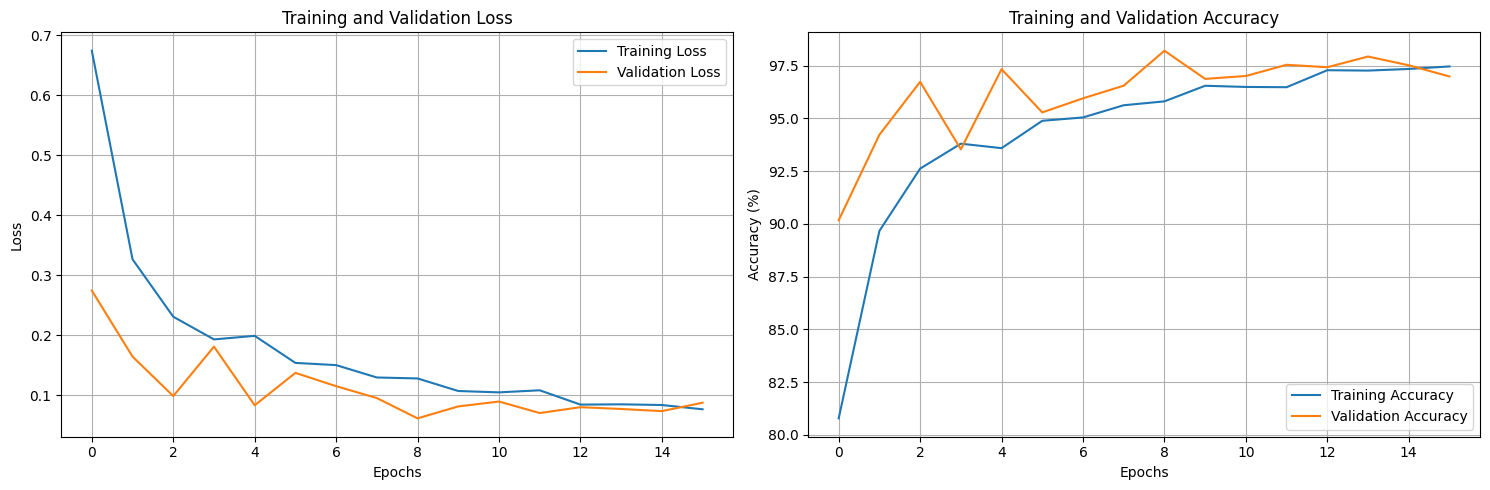

In [ ]:
# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Comprehensive testing function
def comprehensive_test(model, test_loader, class_names, device):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc='Testing')
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            progress_bar.set_postfix({
                'Acc': f'{100.*test_correct/test_total:.2f}%'
            })

    test_accuracy = 100. * test_correct / test_total

    return all_predictions, all_labels, all_probabilities, test_accuracy

# Perform comprehensive testing
print("\nPerforming comprehensive testing...")
test_predictions, test_labels, test_probabilities, test_accuracy = comprehensive_test(
    model, test_loader, class_names, device
)

print(f"\nFinal Test Accuracy: {test_accuracy:.2f}%")
# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(test_labels, test_predictions, target_names=class_names, digits=4))

# Calculate additional metrics
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average='weighted')
print(f"\nWeighted Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Performing comprehensive testing...


Testing: 100%|██████████| 340/340 [00:32<00:00, 10.57it/s, Acc=97.62%]



Final Test Accuracy: 97.62%

Detailed Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab     0.9767    1.0000    0.9882       126
                                 Apple___Black_rot     1.0000    1.0000    1.0000       124
                          Apple___Cedar_apple_rust     1.0000    1.0000    1.0000        55
                                   Apple___healthy     1.0000    0.9878    0.9939       329
                               Blueberry___healthy     0.9464    1.0000    0.9724       300
          Cherry_(including_sour)___Powdery_mildew     1.0000    1.0000    1.0000       210
                 Cherry_(including_sour)___healthy     1.0000    1.0000    1.0000       171
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.8347    0.9806    0.9018       103
                       Corn_(maize)___Common_rust_     0.9958    0.9958    0.9958       239
               Co

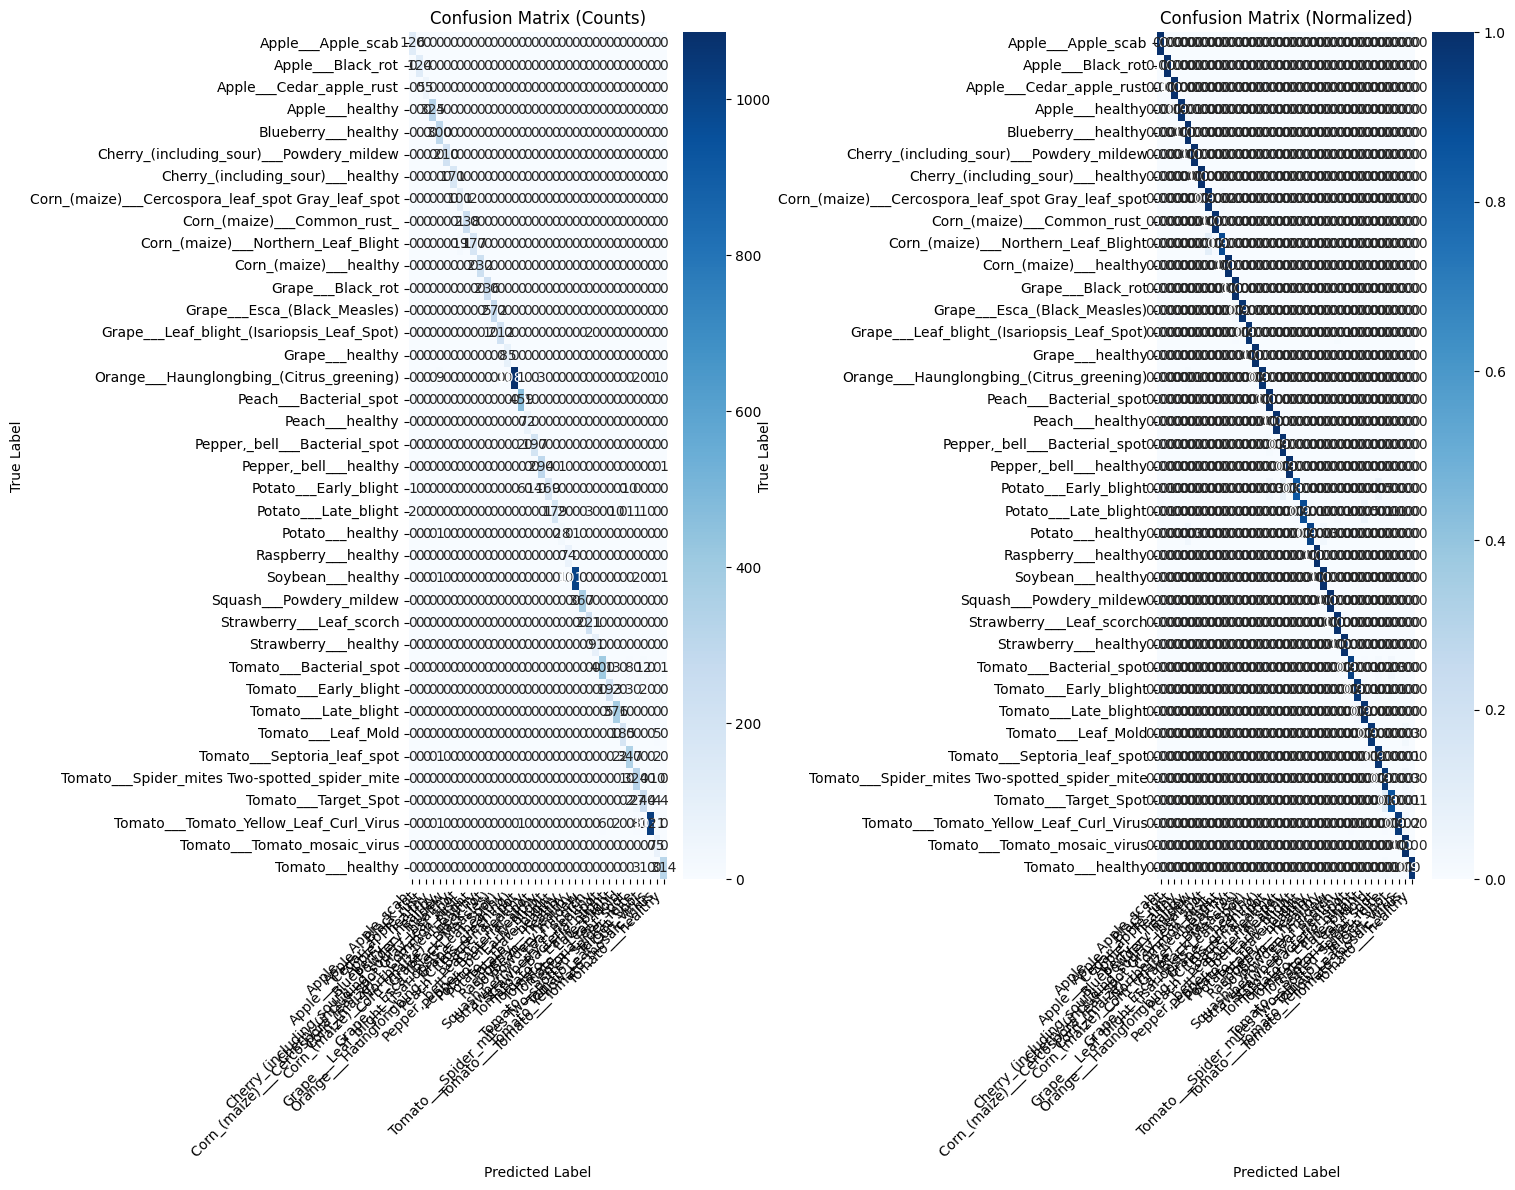


Class-wise Performance (Sorted by Accuracy):
                                                Class    Accuracy  Samples  \
20                              Potato___Early_blight   84.500000      200   
34                               Tomato___Target_Spot   86.832740      281   
21                               Potato___Late_blight   89.500000      200   
9                 Corn_(maize)___Northern_Leaf_Blight   89.847716      197   
22                                   Potato___healthy   93.333333       30   
28                            Tomato___Bacterial_spot   94.117647      425   
35             Tomato___Tomato_Yellow_Leaf_Curl_Virus   96.265173     1071   
29                              Tomato___Early_blight   96.500000      200   
33      Tomato___Spider_mites Two-spotted_spider_mite   96.716418      335   
31                                 Tomato___Leaf_Mold   97.368421      190   
32                        Tomato___Septoria_leaf_spot   98.022599      354   
7   Corn_(maize)__

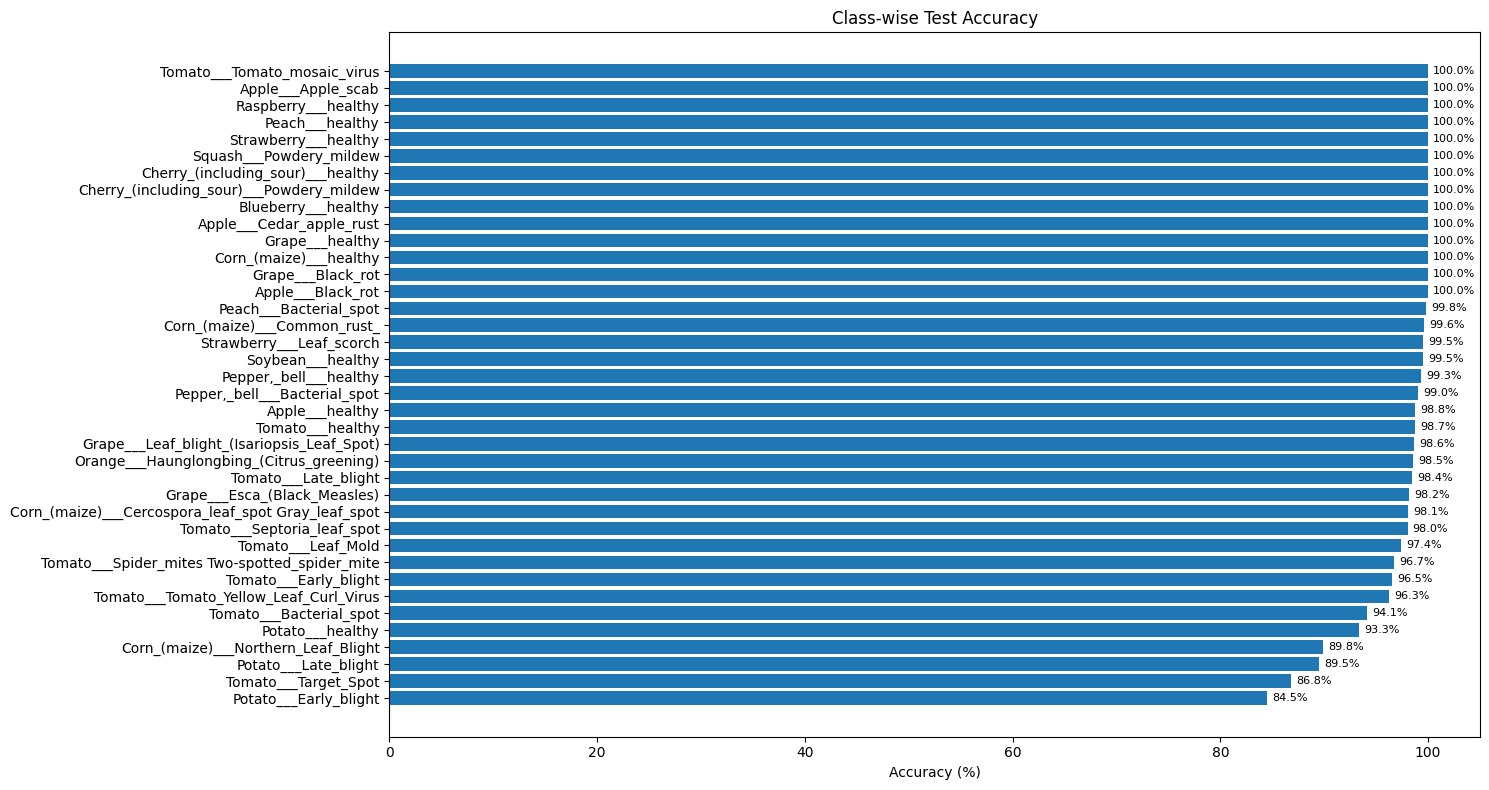

In [ ]:
# Enhanced confusion matrix
plt.figure(figsize=(15, 12))
cm = confusion_matrix(test_labels, test_predictions)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Counts)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.subplot(1, 2, 2)
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Normalized)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# Class-wise accuracy analysis
class_correct = np.zeros(len(class_names))
class_total = np.zeros(len(class_names))

for i in range(len(test_labels)):
    true_class = test_labels[i]
    pred_class = test_predictions[i]
    class_total[true_class] += 1
    if true_class == pred_class:
        class_correct[true_class] += 1

class_accuracy = class_correct / class_total * 100

# Create class performance dataframe
class_performance = pd.DataFrame({
    'Class': class_names,
    'Accuracy': class_accuracy,
    'Samples': class_total.astype(int),
    'Correct': class_correct.astype(int)
}).sort_values('Accuracy')

print("\nClass-wise Performance (Sorted by Accuracy):")
print(class_performance)

# Plot class-wise accuracy
plt.figure(figsize=(15, 8))
bars = plt.barh(range(len(class_performance)), class_performance['Accuracy'])
plt.xlabel('Accuracy (%)')
plt.title('Class-wise Test Accuracy')
plt.yticks(range(len(class_performance)), class_performance['Class'])

# Add accuracy values on bars
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
             f'{class_performance.iloc[i]["Accuracy"]:.1f}%',
             ha='left', va='center', fontsize=8)

plt.tight_layout()
plt.show()


Visualizing predictions...

MODEL PERFORMANCE SUMMARY
Final Test Accuracy: 97.62%
Weighted Precision: 0.9785
Weighted Recall: 0.9762
Weighted F1-Score: 0.9766


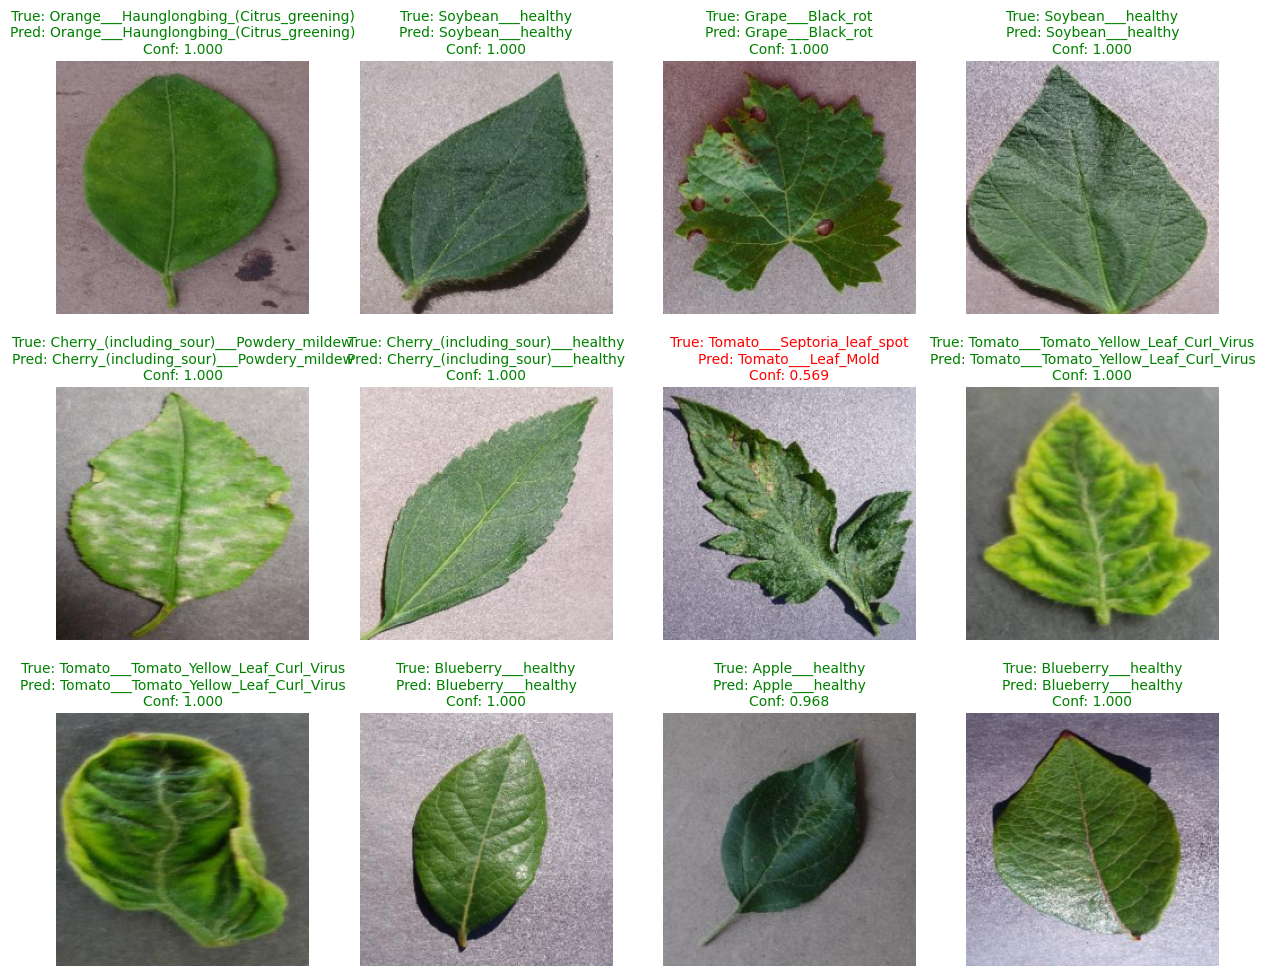

In [ ]:
# Prediction visualization function
def visualize_predictions(model, test_loader, class_names, device, num_samples=12):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 12))

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            probabilities = torch.softmax(outputs, dim=1)

            for i in range(images.size(0)):
                if images_so_far >= num_samples:
                    return

                images_so_far += 1
                ax = plt.subplot(3, 4, images_so_far)
                ax.axis('off')

                # Denormalize image
                img = images[i].cpu().numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)

                ax.imshow(img)

                true_label = class_names[labels[i]]
                pred_label = class_names[preds[i]]
                confidence = probabilities[i][preds[i]].item()

                color = 'green' if preds[i] == labels[i] else 'red'
                ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}',
                           color=color, fontsize=10)

        plt.tight_layout()
        plt.show()

# Visualize predictions
print("\nVisualizing predictions...")
visualize_predictions(model, test_loader, class_names, device)

# Model performance summary
print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(f"Final Test Accuracy: {test_accuracy:.2f}%")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")


In [ ]:
# Calculate top-3 accuracy
def top_k_accuracy(probabilities, labels, k=3):
    top_k_preds = np.argsort(probabilities, axis=1)[:, -k:]
    correct = 0
    for i, label in enumerate(labels):
        if label in top_k_preds[i]:
            correct += 1
    return 100. * correct / len(labels)

top3_accuracy = top_k_accuracy(np.array(test_probabilities), test_labels, k=3)
print(f"Top-3 Accuracy: {top3_accuracy:.2f}%")

Top-3 Accuracy: 99.83%


In [ ]:
# Save final model and training history
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': class_names,
    'test_accuracy': test_accuracy,
    'training_history': {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }
}, 'final_plant_disease_model.pth')

print(f"\nModel saved as 'final_plant_disease_model.pth'")
print(f"Best model saved as 'best_plant_disease_model.pth'")

# Print class distribution
print("\nClass Distribution in Test Set:")
for i, class_name in enumerate(class_names):
    count = np.sum(np.array(test_labels) == i)
    print(f"{class_name}: {count} samples")

print("\nTraining completed successfully!")


Model saved as 'final_plant_disease_model.pth'
Best model saved as 'best_plant_disease_model.pth'

Class Distribution in Test Set:
Apple___Apple_scab: 126 samples
Apple___Black_rot: 124 samples
Apple___Cedar_apple_rust: 55 samples
Apple___healthy: 329 samples
Blueberry___healthy: 300 samples
Cherry_(including_sour)___Powdery_mildew: 210 samples
Cherry_(including_sour)___healthy: 171 samples
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 103 samples
Corn_(maize)___Common_rust_: 239 samples
Corn_(maize)___Northern_Leaf_Blight: 197 samples
Corn_(maize)___healthy: 232 samples
Grape___Black_rot: 236 samples
Grape___Esca_(Black_Measles): 277 samples
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 215 samples
Grape___healthy: 85 samples
Orange___Haunglongbing_(Citrus_greening): 1102 samples
Peach___Bacterial_spot: 460 samples
Peach___healthy: 72 samples
Pepper,_bell___Bacterial_spot: 199 samples
Pepper,_bell___healthy: 296 samples
Potato___Early_blight: 200 samples
Potato___Late_blight: 200

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import os

# Define model paths
DRIVE_MODEL_PATH = '/content/drive/MyDrive/Youtube/trained_models/plant_disease_model.pth'
LOCAL_MODEL_PATH = 'plant_disease_model.pth'

# ✅ Save model to Google Drive and locally
def save_model_to_drive(model, class_names, train_losses, train_accuracies, val_losses, val_accuracies, test_accuracy):
    """Save the trained PyTorch model to Google Drive and locally"""

    # Create directory if it doesn't exist
    os.makedirs('/content/drive/MyDrive/Youtube/trained_models', exist_ok=True)

    # Save to Google Drive
    torch.save({
        'model_state_dict': model.state_dict(),
        'class_names': class_names,
        'training_history': {
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies
        },
        'test_accuracy': test_accuracy,
        'model_architecture': 'EnhancedMobileNetV2'
    }, DRIVE_MODEL_PATH)

    # Save locally
    torch.save({
        'model_state_dict': model.state_dict(),
        'class_names': class_names,
        'training_history': {
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies
        },
        'test_accuracy': test_accuracy,
        'model_architecture': 'EnhancedMobileNetV2'
    }, LOCAL_MODEL_PATH)

    print(f"✅ Model saved to Google Drive: {DRIVE_MODEL_PATH}")
    print(f"✅ Model saved locally: {LOCAL_MODEL_PATH}")

# ✅ Load model from Google Drive
def load_model_from_drive():
    """Load the PyTorch model from Google Drive"""
    try:
        # Check if file exists
        if not os.path.exists(DRIVE_MODEL_PATH):
            print(f"⚠️ No saved model found at: {DRIVE_MODEL_PATH}")
            print("Please train the model first and then save it.")
            return None, None, None

        # Load checkpoint
        checkpoint = torch.load(DRIVE_MODEL_PATH, map_location=device)

        # Initialize model
        num_classes = len(checkpoint['class_names'])
        model = EnhancedMobileNetV2(num_classes=num_classes, pretrained=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(device)
        model.eval()

        print(f"✅ Pretrained model loaded from Drive!")
        print(f"✅ Test accuracy: {checkpoint['test_accuracy']:.2f}%")
        print(f"✅ Number of classes: {num_classes}")

        return model, checkpoint['class_names'], checkpoint

    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None, None, None

# ✅ ACTUALLY SAVE THE MODEL (uncomment and call this after training)
# Make sure you have all these variables defined from your training
save_model_to_drive(model, class_names, train_losses, train_accuracies, val_losses, val_accuracies, test_accuracy)

print("✅ Model saving completed!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model saved to Google Drive: /content/drive/MyDrive/Youtube/trained_models/plant_disease_model.pth
✅ Model saved locally: plant_disease_model.pth
✅ Model saving completed!
